C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


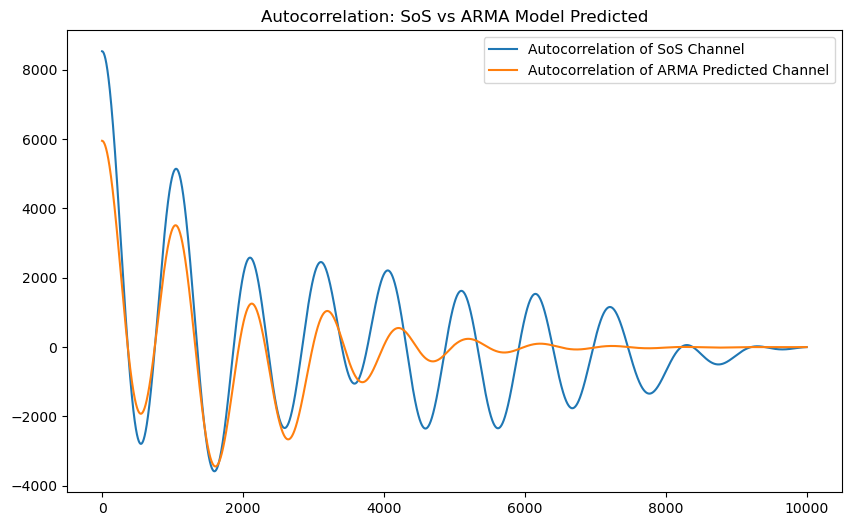

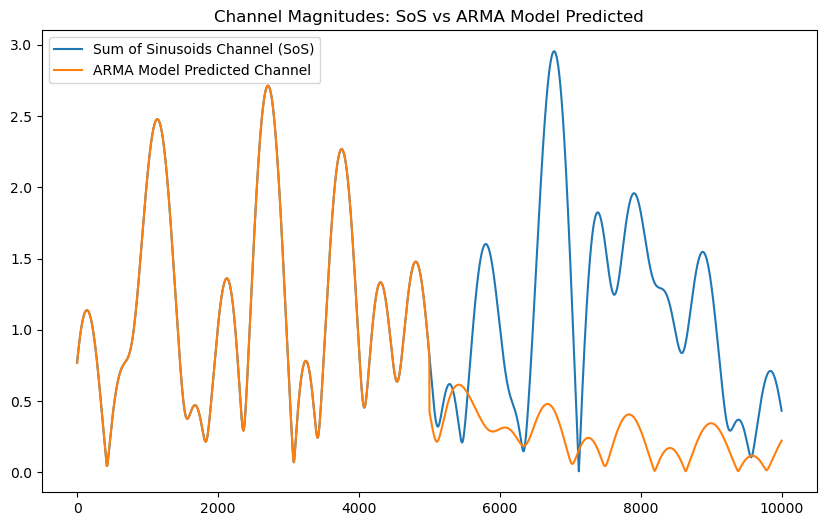

In [32]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import math

# Signal and channel parameters (as per your input)
Fs = 100000    # Sampling frequency
Fc = 2e9       # Carrier frequency
Fd = 100*(100 / Fs)  # Doppler frequency = 100
Tc = 1 / (10 * Fd)  # Coherence time based on Doppler frequency
N = 100000  # Number of data points in the signal
M = 3  # Number of different channel values (multi-path)
packet_size = math.floor(Fs * Tc) // 5  # Size of each packet
header_packet_size = math.floor((1 / 6) * packet_size)  # Known part of the signal (header)
noise_SNR = 10
noise_level = 1 / noise_SNR  # Noise level (1/SNR)
snr_db = 10  # SNR in dB

# Function to generate Jakes random variables (SoS model)
def jakes_sos(P, K, Fs, Fd, N, typ):
    t = np.linspace(0, P/Fs, P)
    omega_d = 2 * np.pi * Fd
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        alpha = np.random.uniform(0, 2 * np.pi, N)
        alpha_m = np.array([((2 * np.pi * n) - np.pi + al)/(4*N) for n, al in enumerate(alpha)])
        a_m = np.random.uniform(0, 2 * np.pi, N)
        b_m = np.random.uniform(0, 2 * np.pi, N)
        
        cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
        real_part = np.sqrt(1/N) * np.sum(cosine_terms, axis=1)
        
        if typ == 'comp':
            sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
            imag_part = np.sqrt(1/N) * np.sum(sine_terms, axis=1)
            jakes_rvs[k] = real_part + 1j * imag_part
        else:
            jakes_rvs[k] = real_part + 1j * 0  # Treat as complex for uniformity
    
    return jakes_rvs

# Generate BPSK signal
def generate_bpsk_signal(N):
    bits = np.random.randint(0, 2, N)
    return 2 * bits - 1  # BPSK: 0 -> -1, 1 -> 1

# Add noise to the signal based on SNR
def add_noise(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

# Function to calculate autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
#Find out the lag value at which the autocorrelation is 0, and take half of that as the ar parameter

# Function to fit ARMA models to the real and imaginary parts of the channel
def fit_arma_model(channel_data, ar_order, ma_order):
    # Fit ARMA model for real part
    real_arma_model = ARIMA(np.real(channel_data), order=(ar_order, 0, ma_order)).fit()
    imag_arma_model = ARIMA(np.imag(channel_data), order=(ar_order, 0, ma_order)).fit()

    return real_arma_model, imag_arma_model

# Function to predict channel values using ARMA models
def predict_arma_channel(real_arma_model, imag_arma_model, steps):
    real_pred = real_arma_model.predict(start=len(real_arma_model.data.endog), end=len(real_arma_model.data.endog) + steps - 1)
    imag_pred = imag_arma_model.predict(start=len(imag_arma_model.data.endog), end=len(imag_arma_model.data.endog) + steps - 1)
    
    predicted_channel = real_pred + 1j * imag_pred
    return predicted_channel

# Main function to predict channels using SoS and ARMA models
def main():
    P = 10000  # Number of samples in the channel
    Fd = 100   # Doppler spread (Hz)
    N = 100    # Number of sinusoids
    K = 1      # Single random process
    typ = 'comp'
    ar_order = 5  # Order of ARMA model (AR component)
    ma_order = 2  # Order of ARMA model (MA component)
    steps = 5000  # Number of future steps to predict using ARMA

    # Generate Jakes channel (sum-of-sinusoids)
    jakes_rvs = jakes_sos(P, K, Fs, Fd, N, typ).flatten()

    # Generate a BPSK signal
    signal = generate_bpsk_signal(P)

    # Transmit signal through the channel
    transmitted_signal = signal * jakes_rvs

    # Add noise to the transmitted signal
    noisy_signal = add_noise(transmitted_signal, snr_db)

    # Fit ARMA model to the generated Jakes fading channel
    real_arma_model, imag_arma_model = fit_arma_model(jakes_rvs, ar_order, ma_order)

    # Predict future channel values using ARMA
    predicted_arma_channel = predict_arma_channel(real_arma_model, imag_arma_model, steps)

    # Combine the SoS channel and ARMA predicted channel
    full_channel_predicted = np.concatenate([jakes_rvs[:P - steps], predicted_arma_channel])

    # 1. Autocorrelation of SoS channel and ARMA model predicted channel
    autocorr_sos = autocorr(np.real(jakes_rvs))
    autocorr_predicted = autocorr(np.real(full_channel_predicted))

    plt.figure(figsize=(10, 6))
    plt.plot(autocorr_sos, label='Autocorrelation of SoS Channel')
    plt.plot(autocorr_predicted, label='Autocorrelation of ARMA Predicted Channel')
    plt.legend()
    plt.title('Autocorrelation: SoS vs ARMA Model Predicted')
    plt.show()

    # 2. Plot the actual channel values of the SoS model and ARMA model
    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(jakes_rvs), label='Sum of Sinusoids Channel (SoS)')
    plt.plot(np.abs(full_channel_predicted), label='ARMA Model Predicted Channel')
    plt.legend()
    plt.title('Channel Magnitudes: SoS vs ARMA Model Predicted')
    plt.show()

if __name__ == "__main__":
    main()
